<a href="https://colab.research.google.com/github/nattntn/DPDM2024/blob/main/final_dpdm_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

โหลดข้อมูล Metabolites จำนวน 51 samples จาก https://drive.google.com/drive/folders/18BGc4-dxHwuSB6ep3PmHa688Fiww23CI?usp=sharing
ซี่งประกอบด้วยค่า X ขนาด 51x65536 ซึ่งเป็นค่าความเข้มข้นขององค์ประกอบ และ ppm ขนาด 65536 ซึ่งเป็นค่า Chemical shift
ดังรูป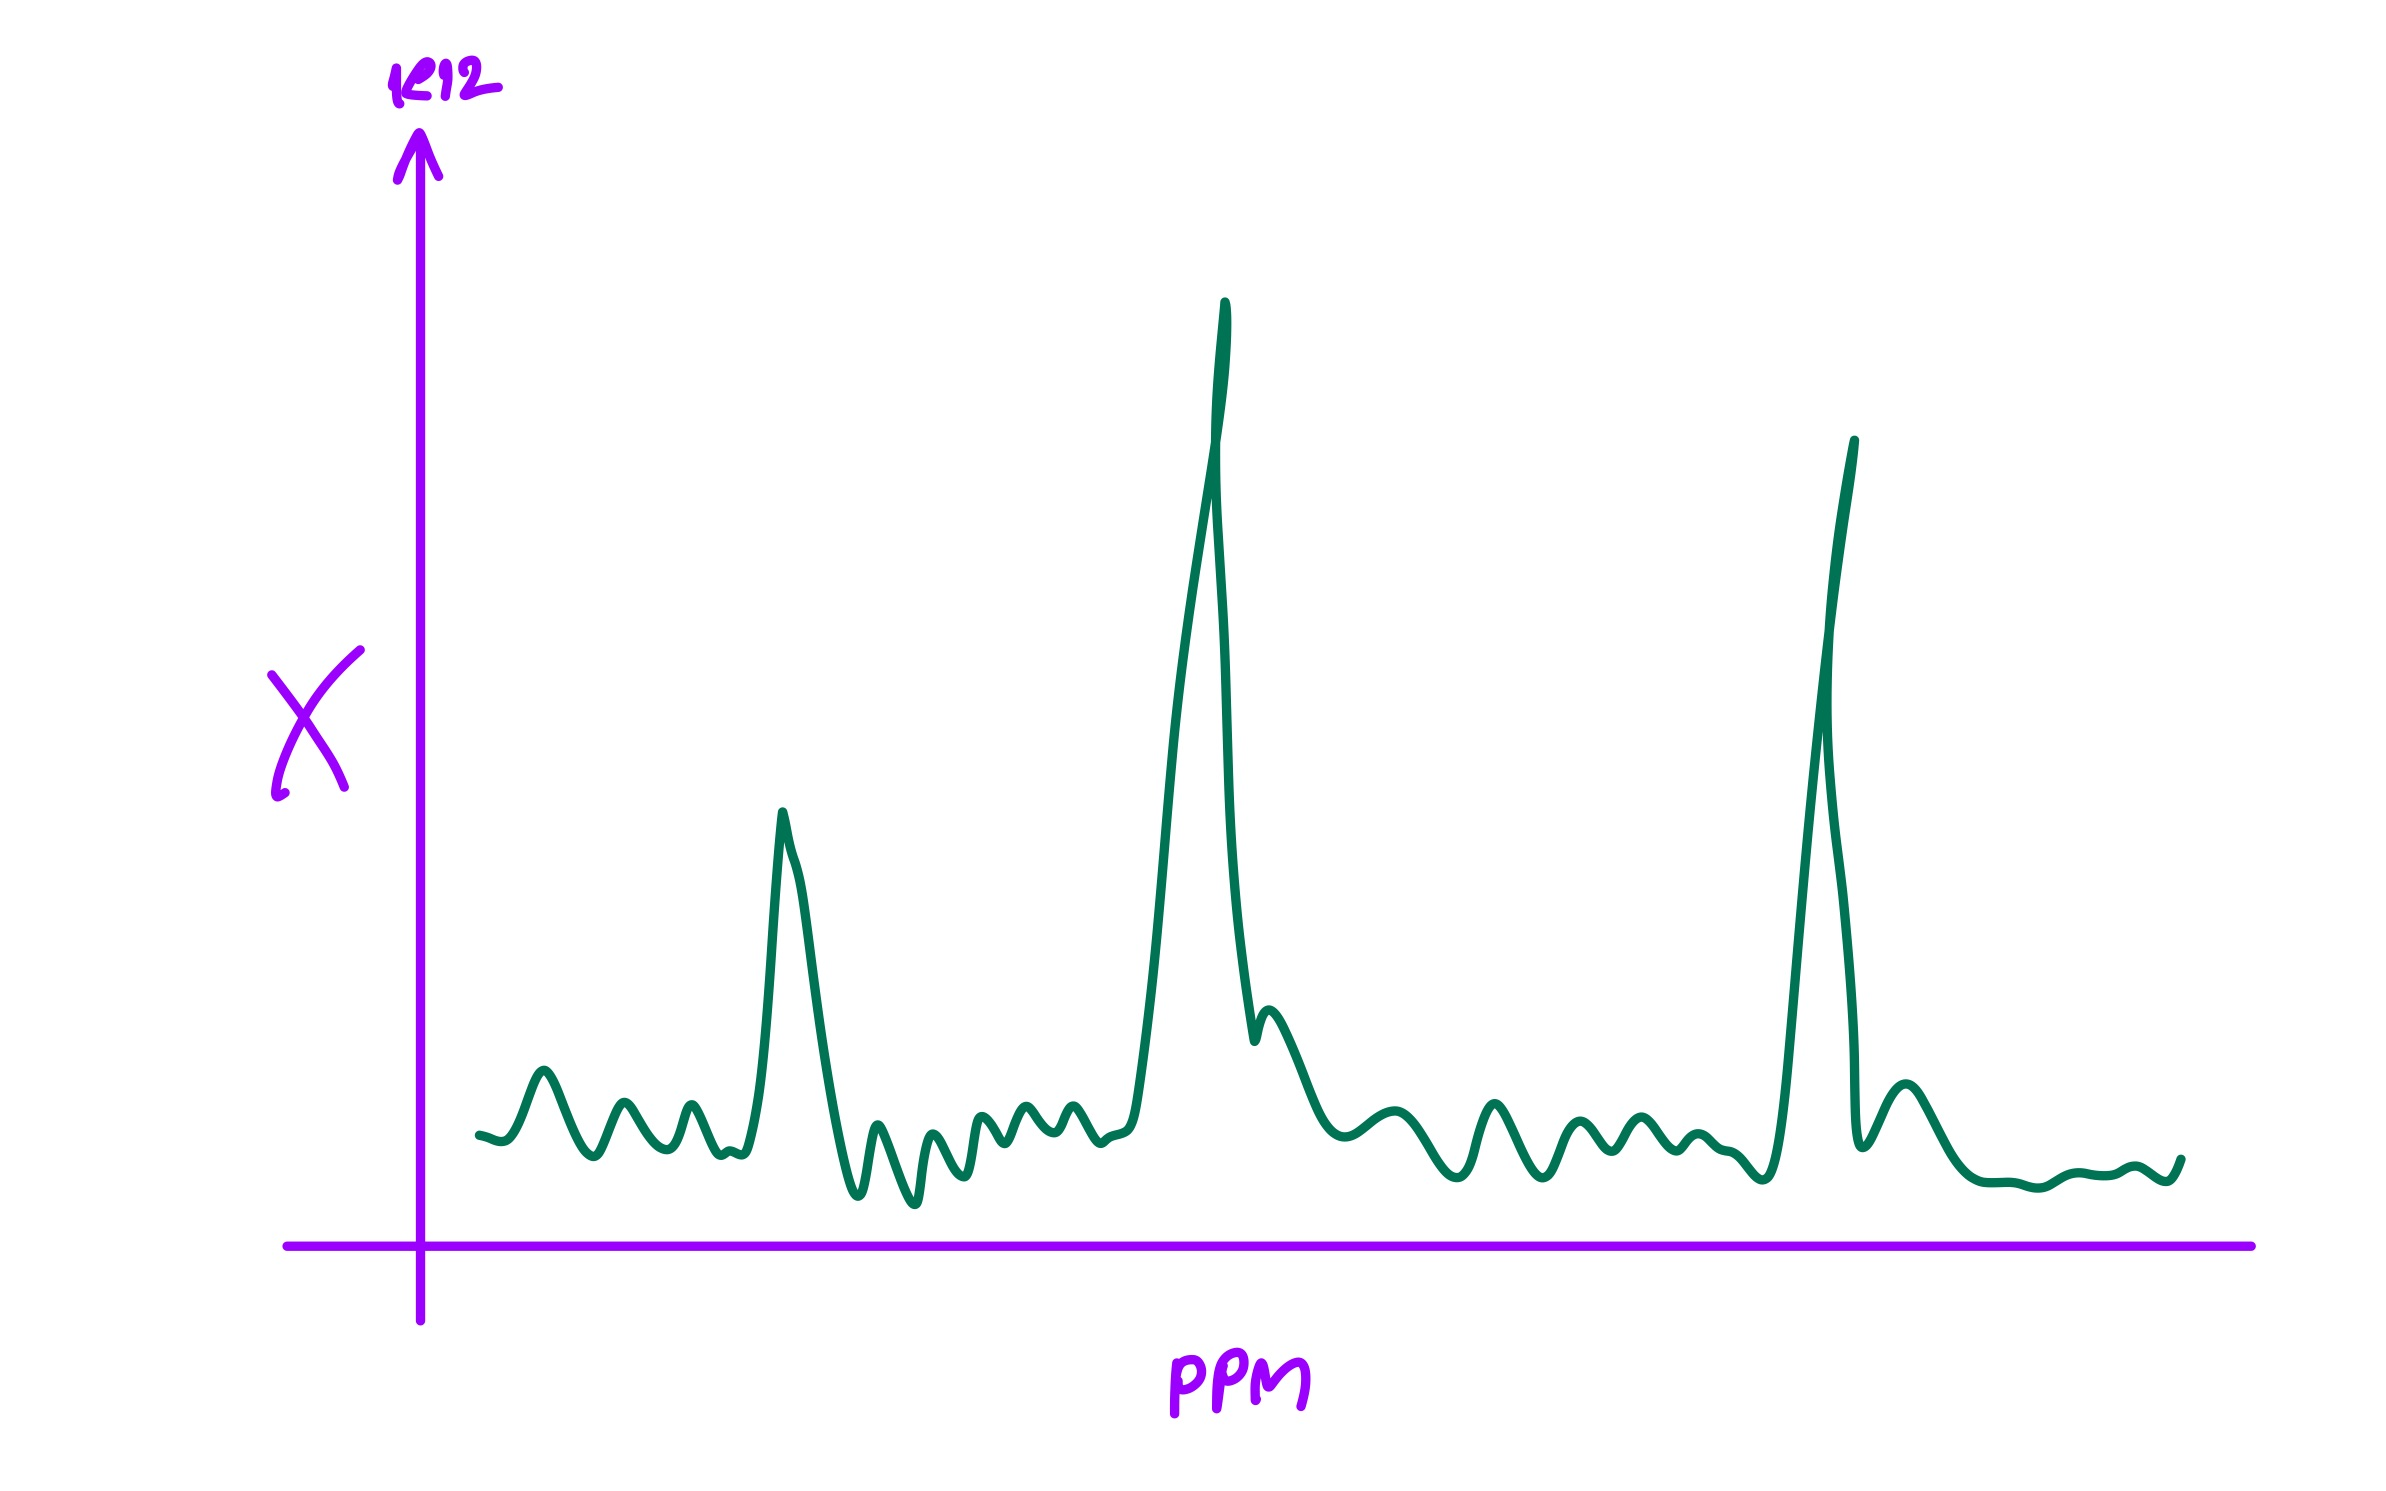

จัดการข้อมูลโดย 1 ตัด ข้อมูลที่อยู่นอกช่วงที่สนใจ ppm น้อยกว่า 0 และ มากกว่า 9.5
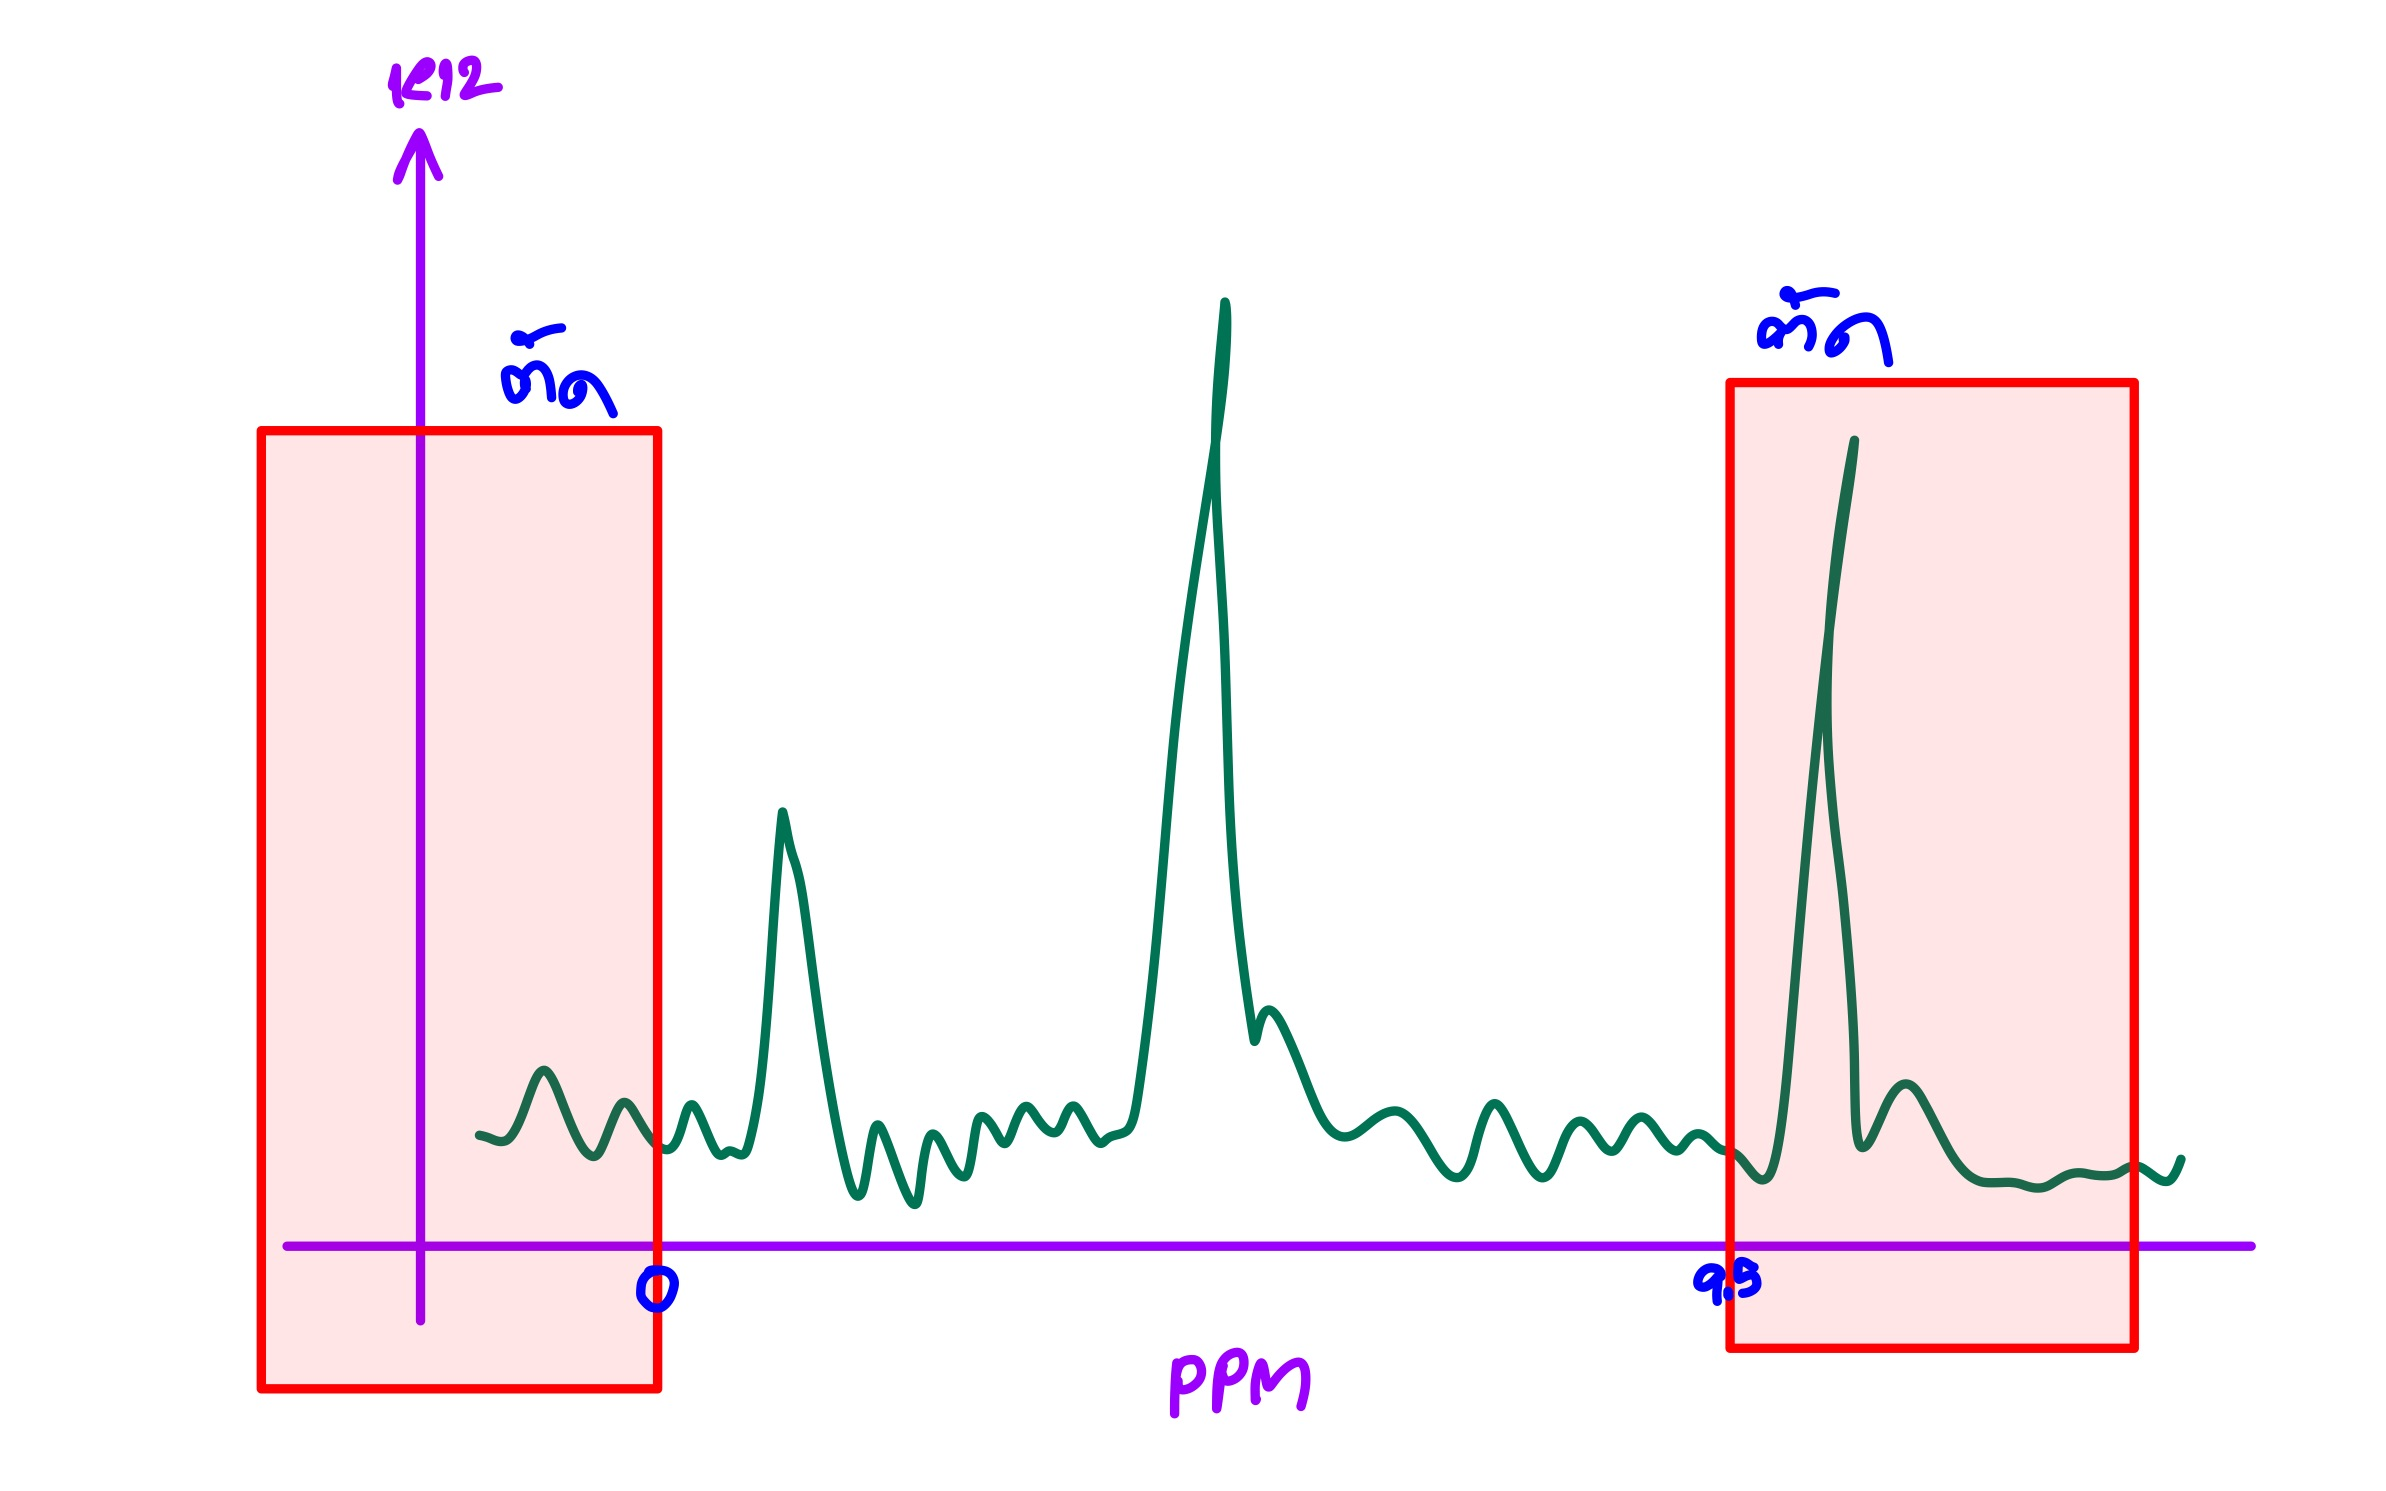

และ 2 quantize ข้อมูลโดยลดจำนวนข้อมูล ให้เหลือเพียง 51 x 400 โดยรวมข้อมูลที่อยู่ข้างกันและเลือกค่า max X
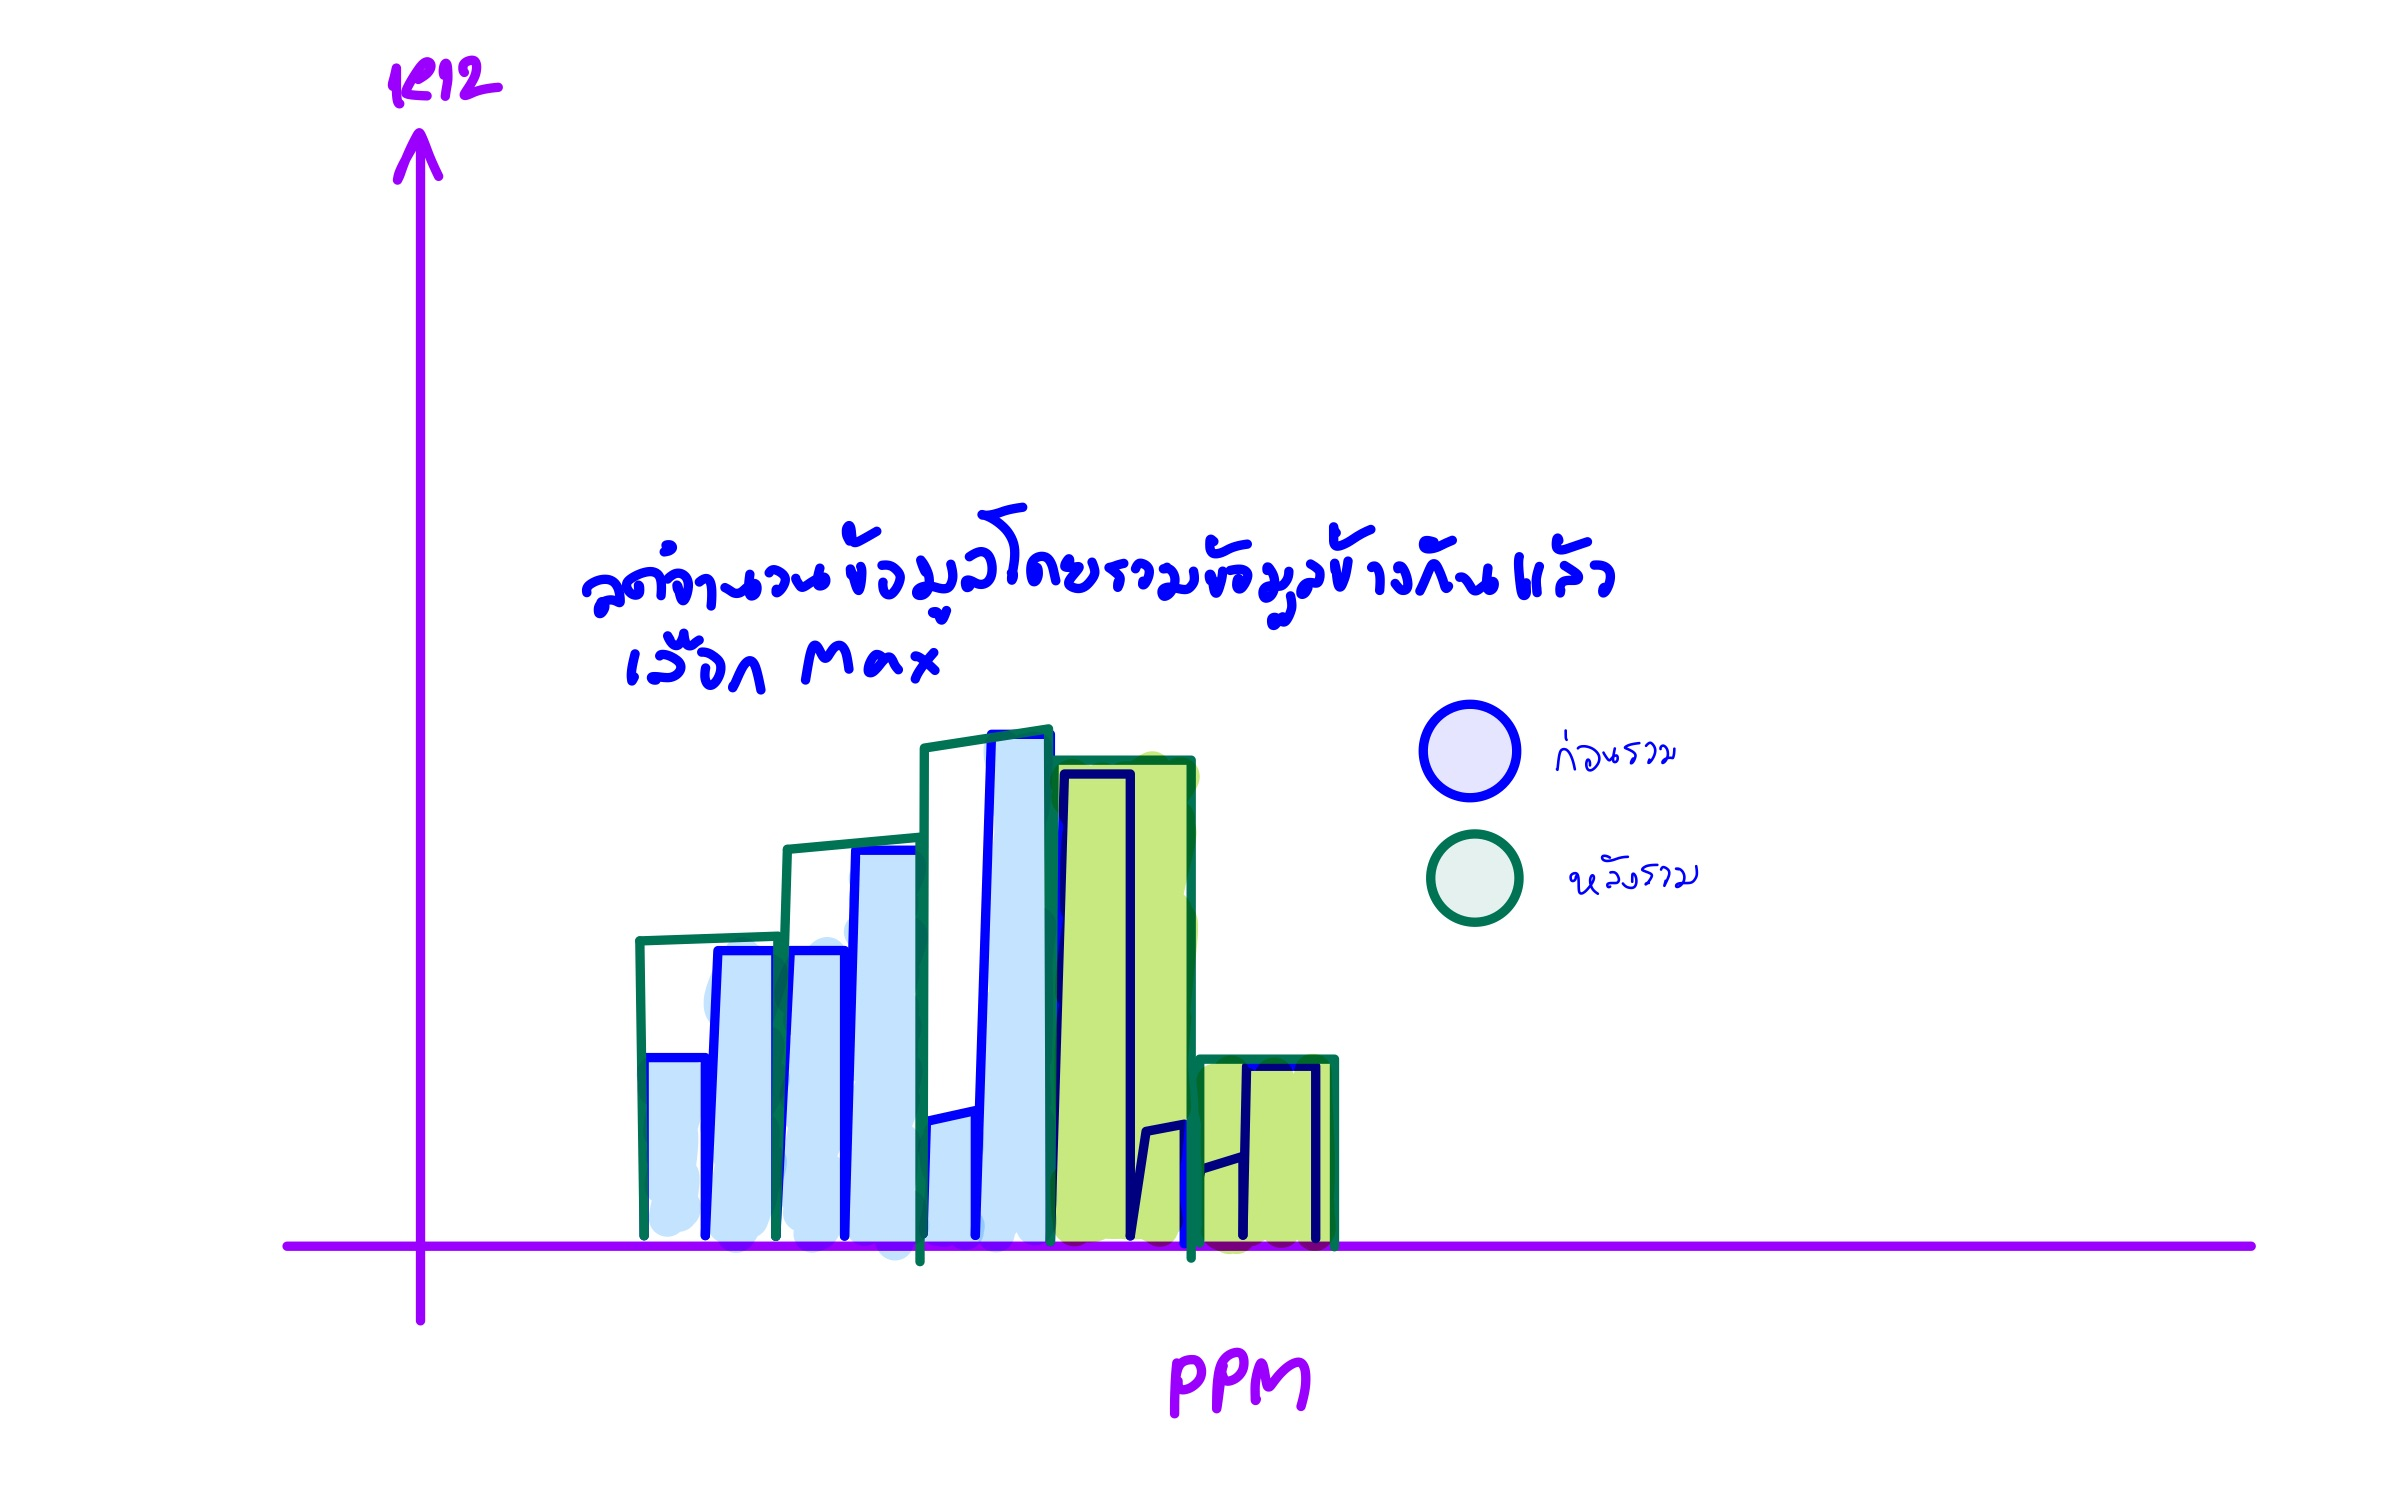

ข้อสอบ
0. preprocess ข้อมูลตามคำแนะนำข้างบน
1. หาทาง visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น
2. วิเคราะห์ว่าข้อมูลทั้ง 51 จุด มาจากสาร metabolites ทั้งหมดกี่กลุ่ม (ด้วย K-mean clustering และ Hierachical clustering)


# 0. preprocess ข้อมูลตามคำแนะนำข้างบน

In [1]:
import pandas as pd
import shutil
from IPython.display import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pickle

file_path = '/content/gdrive/MyDrive/Final Metabolites Data/Xnn_ppm.pickle'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

# ตรวจสอบข้อมูล
print(type(data))
print(len(data))

data

<class 'tuple'>
2


(array([[ 1.36984969e+07,  1.36904279e+07,  1.27889682e+07, ...,
          1.88668440e+06,  3.11779437e+06,  3.34950400e+06],
        [ 8.55679993e+06,  7.90758455e+06,  7.28975667e+06, ...,
          1.36576000e+06,  1.36576000e+06,  1.36576000e+06],
        [ 4.74035200e+06,  4.74035200e+06,  4.74035200e+06, ...,
         -2.02200274e+06, -2.32252840e+06, -3.07843664e+06],
        ...,
        [ 3.86329400e+07,  3.86329400e+07,  3.86329400e+07, ...,
         -4.37613458e+08, -4.38095321e+08, -4.40187284e+08],
        [ 9.94168277e+05,  9.94168277e+05,  9.94168277e+05, ...,
         -4.62360904e+05,  4.27633911e+05, -1.72847014e+06],
        [-1.41491086e+05, -1.41491086e+05, -1.41491086e+05, ...,
          1.16130230e+07,  1.16073431e+07,  8.35909427e+06]]),
 array([10.87128   , 10.87109488, 10.87090976, ..., -1.26026981,
        -1.26045493, -1.26064005]))

ซี่งประกอบด้วยค่า **X** ขนาด 51x65536 ซึ่งเป็นค่าความเข้มข้นขององค์ประกอบ (intensity)  
มี 51 ตัวอย่าง (samples)  
มี 65,536 ตัวแปร (features) อาจจะสลับ  


และ **ppm** ขนาด 65536 ซึ่งเป็นค่า Chemical shift  
target: Chemical shift ในหน่วย ppm (parts per million)

In [4]:
X, ppm = data

In [5]:
X

array([[ 1.36984969e+07,  1.36904279e+07,  1.27889682e+07, ...,
         1.88668440e+06,  3.11779437e+06,  3.34950400e+06],
       [ 8.55679993e+06,  7.90758455e+06,  7.28975667e+06, ...,
         1.36576000e+06,  1.36576000e+06,  1.36576000e+06],
       [ 4.74035200e+06,  4.74035200e+06,  4.74035200e+06, ...,
        -2.02200274e+06, -2.32252840e+06, -3.07843664e+06],
       ...,
       [ 3.86329400e+07,  3.86329400e+07,  3.86329400e+07, ...,
        -4.37613458e+08, -4.38095321e+08, -4.40187284e+08],
       [ 9.94168277e+05,  9.94168277e+05,  9.94168277e+05, ...,
        -4.62360904e+05,  4.27633911e+05, -1.72847014e+06],
       [-1.41491086e+05, -1.41491086e+05, -1.41491086e+05, ...,
         1.16130230e+07,  1.16073431e+07,  8.35909427e+06]])

In [6]:
X.shape

(51, 65536)

In [7]:
ppm

array([10.87128   , 10.87109488, 10.87090976, ..., -1.26026981,
       -1.26045493, -1.26064005])

In [8]:
ppm.shape

(65536,)

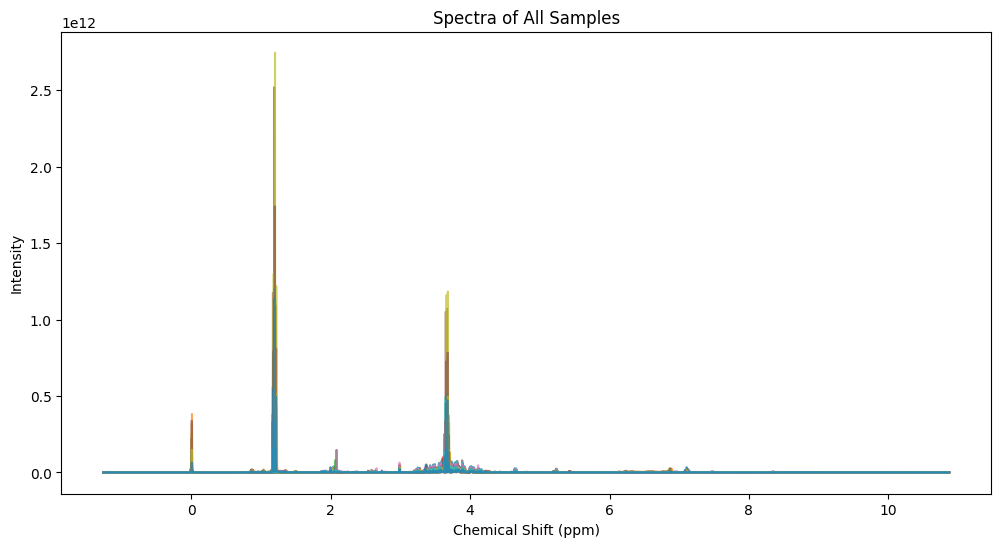

In [9]:
# plot กราฟสำหรับทุกตัวอย่างใน X
plt.figure(figsize=(12, 6))  # ตั้งค่าขนาดของกราฟเพื่อให้ดูชัดเจนขึ้น
for i in range(X.shape[0]):  # วนลูปทุกตัวอย่าง
    plt.plot(ppm, X[i, :], label=f'Sample {i + 1}', alpha=0.7)  # ใช้ alpha เพื่อลดความทึบของเส้น

plt.title('Spectra of All Samples')
plt.xlabel('Chemical Shift (ppm)')
plt.ylabel('Intensity')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # เลื่อน legend ไปด้านข้างเพื่อไม่ให้บังกราฟ
plt.show()

## จัดการข้อมูลโดย 1 ตัด ข้อมูลที่อยู่นอกช่วงที่สนใจ ppm น้อยกว่า 0 และ มากกว่า 9.5

In [10]:
selected_ppm = ppm[(ppm >= 0)&(ppm <= 9.5)]
print(selected_ppm.shape)
selected_ppm

(51318,)


array([9.49990190e+00, 9.49971678e+00, 9.49953166e+00, ...,
       4.05794376e-04, 2.20673142e-04, 3.55519087e-05])

In [11]:
X.shape

(51, 65536)

In [12]:
X_selected = X[:, (ppm >= 0)&(ppm <= 9.5)]
X_selected

array([[-2.23825289e+07, -2.26013459e+07, -2.26775976e+07, ...,
         1.23904095e+11,  1.27039191e+11,  1.28168704e+11],
       [-1.58822034e+07, -1.57022793e+07, -1.53798619e+07, ...,
         9.72358899e+10,  9.91425866e+10,  9.99790605e+10],
       [-9.76243338e+06, -9.63579561e+06, -1.00830466e+07, ...,
         7.89238221e+10,  8.03747999e+10,  8.11650686e+10],
       ...,
       [-1.06418253e+08, -1.09006437e+08, -1.08945267e+08, ...,
         1.67200384e+10,  1.57979392e+10,  1.49891330e+10],
       [-9.06714900e+06, -8.37267192e+06, -3.06542253e+06, ...,
         9.34012377e+08,  9.13715222e+08,  8.92615673e+08],
       [ 1.78534889e+07,  1.14285126e+07,  3.83029976e+06, ...,
         1.17769744e+10,  1.11488461e+10,  1.05771607e+10]])

In [13]:
X_selected.shape

(51, 51318)

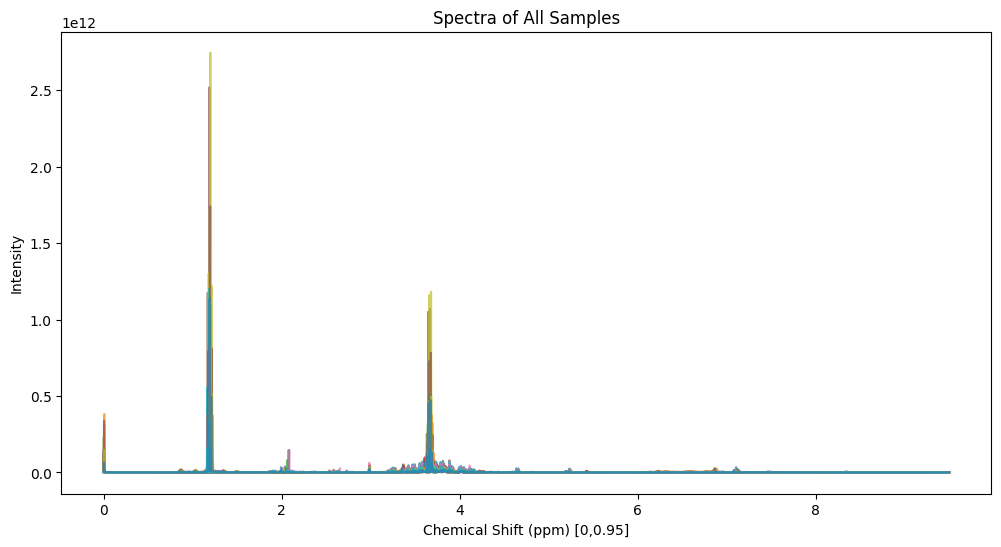

In [14]:
# plot กราฟสำหรับทุกตัวอย่างใน X
plt.figure(figsize=(12, 6))  # ตั้งค่าขนาดของกราฟเพื่อให้ดูชัดเจนขึ้น
for i in range(X_selected.shape[0]):  # วนลูปทุกตัวอย่าง
    plt.plot(selected_ppm, X_selected[i, :], label=f'Sample {i + 1}', alpha=0.7)  # ใช้ alpha เพื่อลดความทึบของเส้น

plt.title('Spectra of All Samples')
plt.xlabel('Chemical Shift (ppm) [0,0.95]')
plt.ylabel('Intensity')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # เลื่อน legend ไปด้านข้างเพื่อไม่ให้บังกราฟ
plt.show()

## 2 quantize ข้อมูลโดยลดจำนวนข้อมูล ให้เหลือเพียง 51 x 400 โดยรวมข้อมูลที่อยู่ข้างกันและเลือกค่า max X

ในการทำ quantize ข้อมูลตามโจทย์ที่ให้มา โดยการลดขนาดข้อมูลจากเดิม (เช่น
51
×
𝑀) ให้เหลือ
51
×
400  
 โดยการรวมข้อมูลที่อยู่ข้างกันและเลือกค่าที่เป็นค่าสูงสุด (max) ของแต่ละช่วง สามารถทำได้ตามขั้นตอนต่อไปนี้:

คำนวณขนาดของแต่ละช่วง (bin size): แบ่งข้อมูลทั้งหมดออกเป็น 400 ช่วงที่เท่า ๆ กัน  
เลือกค่าสูงสุดในแต่ละช่วง: สำหรับแต่ละตัวอย่าง (sample) ให้คำนวณค่าสูงสุด (max) ภายในแต่ละช่วง  

In [15]:
import numpy as np

# จำนวน bins ที่ต้องการ (400)
num_bins = 400

# คำนวณขนาดของแต่ละช่วง
bin_size = X_selected.shape[1] // num_bins

# ทำการ quantize โดยการเลือกค่าสูงสุดในแต่ละช่วง
X_quantized = np.array([
    np.max(X_selected[:, i * bin_size:(i + 1) * bin_size], axis=1)
    for i in range(num_bins)
]).T # .T (transpose) เพื่อเปลี่ยนรูปร่างของ array ให้อยู่ในรูปแบบ 51×400

# แสดงขนาดของข้อมูลหลังจากทำ quantization
print("Shape of X after quantization:", X_quantized.shape)


Shape of X after quantization: (51, 400)


In [16]:
X_quantized

array([[-1.09661551e+07, -1.47819376e+07, -1.32520133e+07, ...,
         1.45939172e+08,  2.84816430e+08,  1.11972151e+09],
       [-9.80232950e+06, -1.12563864e+07, -1.11179388e+07, ...,
         1.41795843e+08,  3.01300851e+08,  1.18119745e+09],
       [-7.89197892e+06, -7.54651974e+06, -6.89197365e+06, ...,
         1.64836722e+08,  3.38647994e+08,  1.35829862e+09],
       ...,
       [-6.39938371e+07, -5.32964310e+07, -6.01670823e+07, ...,
        -2.70779868e+08, -2.61279903e+08,  4.38097709e+08],
       [ 5.20920643e+07,  8.96035149e+07,  2.18613110e+08, ...,
         4.13522147e+07,  6.65719791e+07,  2.80633204e+08],
       [ 2.53153212e+07,  3.60221466e+07,  2.39985557e+07, ...,
         1.32403932e+08,  2.58355603e+08,  1.51610806e+09]])

In [17]:
# ทำ quantize สำหรับ ppm โดยการแบ่งเป็น 400 ช่วง
ppm_quantized = np.array([
    np.mean(selected_ppm[i * bin_size:(i + 1) * bin_size])
    for i in range(num_bins)
])

# แสดงขนาดของ ppm หลังจากทำ quantization
print("Length of ppm after quantization:", ppm_quantized.shape[0])


Length of ppm after quantization: 400


In [18]:
ppm_quantized

array([9.4881467 , 9.46445118, 9.44075567, 9.41706015, 9.39336463,
       9.36966911, 9.3459736 , 9.32227808, 9.29858256, 9.27488704,
       9.25119152, 9.22749601, 9.20380049, 9.18010497, 9.15640945,
       9.13271393, 9.10901842, 9.0853229 , 9.06162738, 9.03793186,
       9.01423634, 8.99054083, 8.96684531, 8.94314979, 8.91945427,
       8.89575875, 8.87206324, 8.84836772, 8.8246722 , 8.80097668,
       8.77728117, 8.75358565, 8.72989013, 8.70619461, 8.68249909,
       8.65880358, 8.63510806, 8.61141254, 8.58771702, 8.5640215 ,
       8.54032599, 8.51663047, 8.49293495, 8.46923943, 8.44554391,
       8.4218484 , 8.39815288, 8.37445736, 8.35076184, 8.32706632,
       8.30337081, 8.27967529, 8.25597977, 8.23228425, 8.20858874,
       8.18489322, 8.1611977 , 8.13750218, 8.11380666, 8.09011115,
       8.06641563, 8.04272011, 8.01902459, 7.99532907, 7.97163356,
       7.94793804, 7.92424252, 7.900547  , 7.87685148, 7.85315597,
       7.82946045, 7.80576493, 7.78206941, 7.75837389, 7.73467

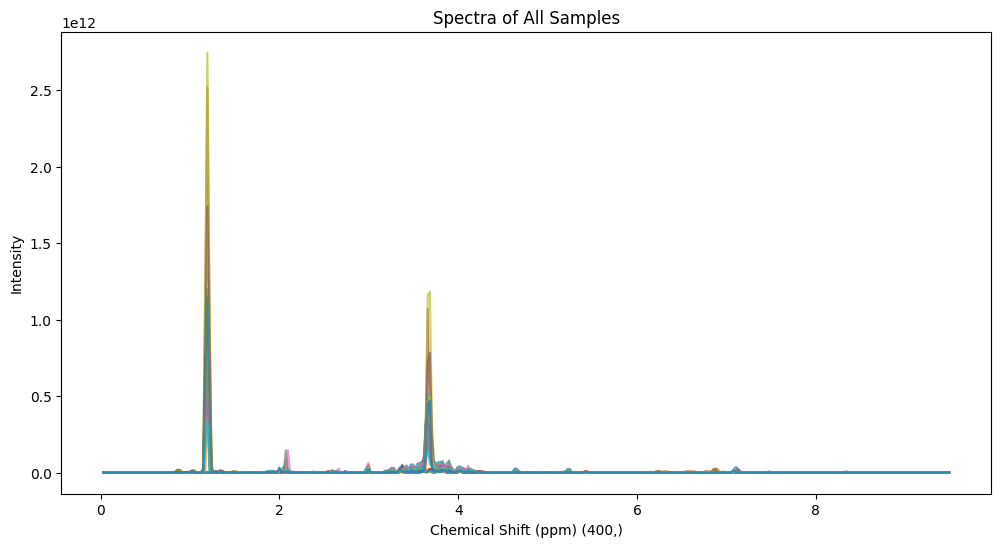

In [19]:
# plot กราฟสำหรับทุกตัวอย่างใน X
plt.figure(figsize=(12, 6))  # ตั้งค่าขนาดของกราฟเพื่อให้ดูชัดเจนขึ้น
for i in range(X_quantized.shape[0]):  # วนลูปทุกตัวอย่าง
    plt.plot(ppm_quantized, X_quantized[i, :], label=f'Sample {i + 1}', alpha=0.7)  # ใช้ alpha เพื่อลดความทึบของเส้น

plt.title('Spectra of All Samples')
plt.xlabel('Chemical Shift (ppm) (400,)')
plt.ylabel('Intensity')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # เลื่อน legend ไปด้านข้างเพื่อไม่ให้บังกราฟ
plt.show()

# 1. หาทาง visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น

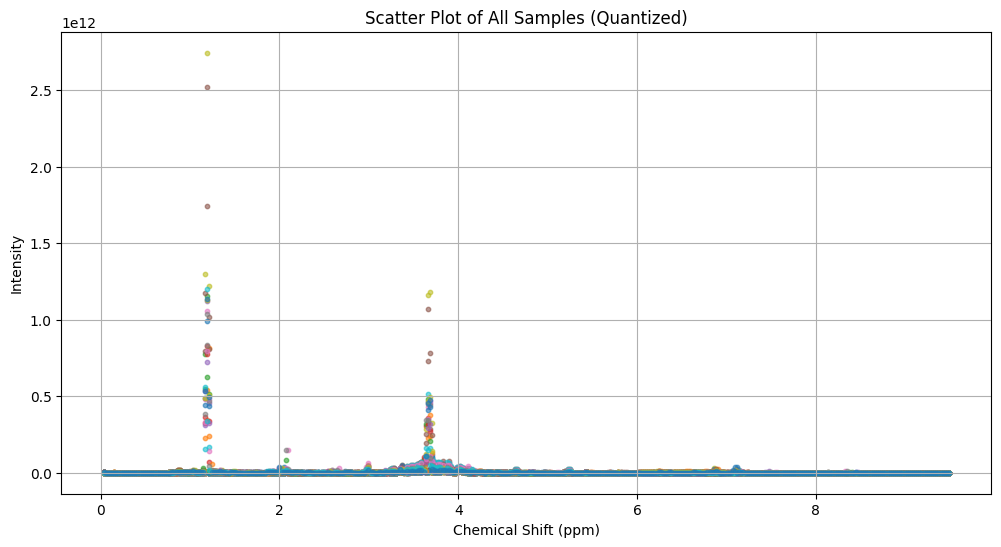

In [20]:
import matplotlib.pyplot as plt

# Scatter plot สำหรับตัวอย่างทั้งหมด 51 ตัวอย่าง
plt.figure(figsize=(12, 6))
for i in range(X_quantized.shape[0]):  # วนลูปทุกตัวอย่าง
    plt.scatter(ppm_quantized, X_quantized[i, :], alpha=0.6, s=10)  # s=10 เพื่อกำหนดขนาดของจุด

# ตั้งค่าการแสดงผล
plt.title('Scatter Plot of All Samples (Quantized)')
plt.xlabel('Chemical Shift (ppm)')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()


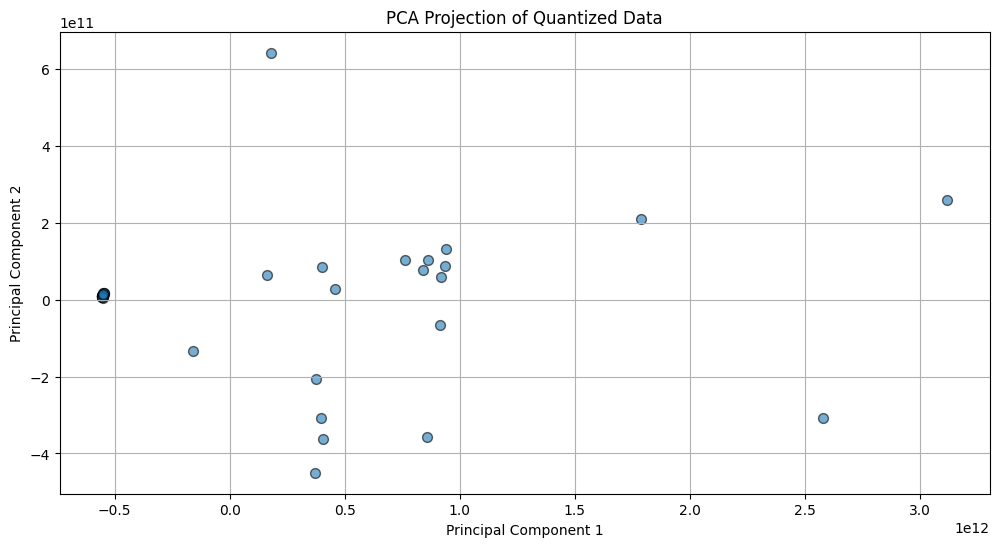

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ทำ PCA ลดมิติข้อมูลเหลือ 2 มิติ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_quantized)

# สร้าง scatter plot แสดงผลการกระจายตัวของข้อมูล
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, edgecolors='k')
plt.title('PCA Projection of Quantized Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separate the features from the target variable
X = X_quantized
# y = X_p['Class_Numeric']

# Standardize the features
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# # Create a DataFrame with the principal components and the target variable
# finalDf = pd.concat([principalDf, pd.DataFrame(y)], axis = 1)

In [23]:
principalDf

,principal component 1,principal component 2
0,-8.908003,-1.166317
1,-9.616915,-0.474946
2,-11.817936,1.842341
3,-11.936486,1.669942
4,-9.781988,-1.902658
5,-9.581563,-0.835798
6,-11.803480,1.670684
7,-10.028340,0.077299
8,-8.314967,-1.448274
9,-9.911156,0.416131


<ipython-input-24-98bd62533233>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 51)  # ใช้ colormap 'tab20' ที่รองรับหลายสี


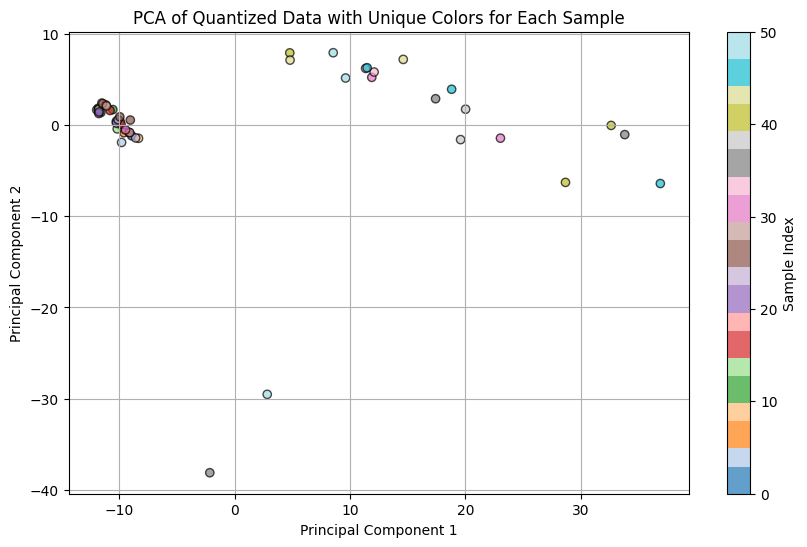

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# สร้างสีที่แตกต่างกันสำหรับแต่ละตัวอย่าง (51 สี)
colors = plt.cm.get_cmap('tab20', 51)  # ใช้ colormap 'tab20' ที่รองรับหลายสี

# Plot the PCA results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                      c=np.arange(51), cmap=colors, alpha=0.7, edgecolors='k')

# Add color bar to indicate the index of samples
plt.colorbar(scatter, label='Sample Index')
plt.title('PCA of Quantized Data with Unique Colors for Each Sample')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


จากกราฟ อาจจะทำได้ปประมาณ 2 กลุ่ม

# 2. วิเคราะห์ว่าข้อมูลทั้ง 51 จุด มาจากสาร metabolites ทั้งหมดกี่กลุ่ม (ด้วย K-mean clustering และ Hierachical clustering)

## K-mean clustering

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

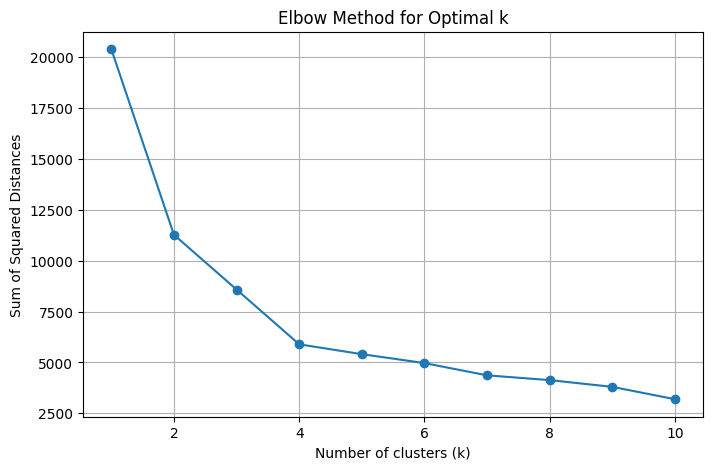

In [26]:
# หาจำนวนกลุ่มที่เหมาะสมโดยใช้ Elbow Method
ssd = []  # Sum of squared distances
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # ใช้ข้อมูลที่ทำ Standardization แล้ว
    ssd.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)
plt.show()

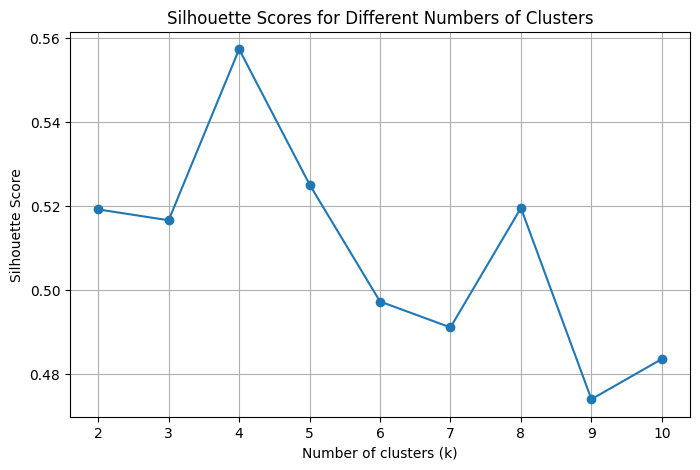

In [27]:
# หาค่า Silhouette Score สำหรับจำนวนกลุ่มต่าง ๆ
silhouette_scores = []

for k in range(2, 11):  # Silhouette ไม่สามารถคำนวณได้สำหรับ k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Elbow Method: ตำแหน่งที่ค่า Sum of Squared Distances (SSD) ลดลงอย่างชัดเจนก่อนที่จะเริ่มลดลงอย่างช้าลง คือ k = 4

Silhouette Score: กราฟแสดงค่า Silhouette Score สูงสุดที่ประมาณ
k=4 ซึ่งบ่งบอกถึงคุณภาพของการจัดกลุ่มที่ดีที่สุดในกรณีนี้

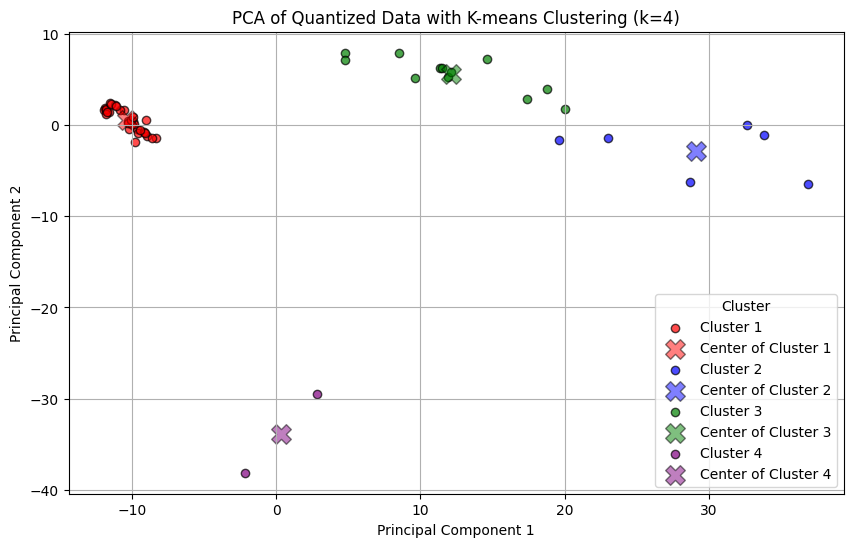

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ใช้ K-means clustering โดยกำหนดจำนวนกลุ่มเป็น 4
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)  # X_scaled คือข้อมูลที่ทำ Standardization แล้ว

principalDf['Cluster'] = cluster_labels

colors = ['red', 'blue', 'green', 'purple']

# แสดงผลการจัดกลุ่มด้วย PCA โดยใช้สีที่กำหนดเอง
plt.figure(figsize=(10, 6))
for cluster in range(4):  # วนลูปตามจำนวนกลุ่ม
    cluster_data = principalDf[principalDf['Cluster'] == cluster]
    plt.scatter(cluster_data['principal component 1'], cluster_data['principal component 2'],
                color=colors[cluster], label=f'Cluster {cluster + 1}', alpha=0.7, edgecolors='k')

    # คำนวณจุดศูนย์กลางของแต่ละกลุ่ม
    center_x = cluster_data['principal component 1'].mean()
    center_y = cluster_data['principal component 2'].mean()

    # Plot จุดศูนย์กลาง
    plt.scatter(center_x, center_y, color=colors[cluster], edgecolor='black',
                s=200, marker='X', label=f'Center of Cluster {cluster + 1}', alpha=0.5)  # ใช้ marker='X' เพื่อแสดงเป็นจุดศูนย์กลาง

# เพิ่ม legend และตั้งค่าแสดงผล
plt.legend(title='Cluster')
plt.title('PCA of Quantized Data with K-means Clustering (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [39]:
principalDf.groupby('Cluster').size()

,0
Cluster,
0,31
1,6
2,12
3,2


##  Hierarchical Clustering

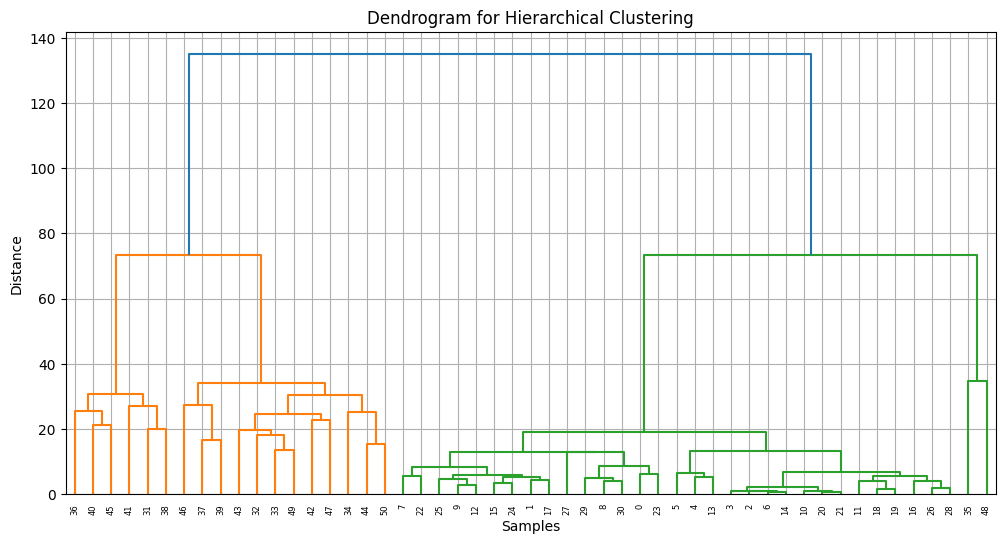

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# สร้าง linkage matrix โดยใช้วิธี 'ward'
Z = linkage(X_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


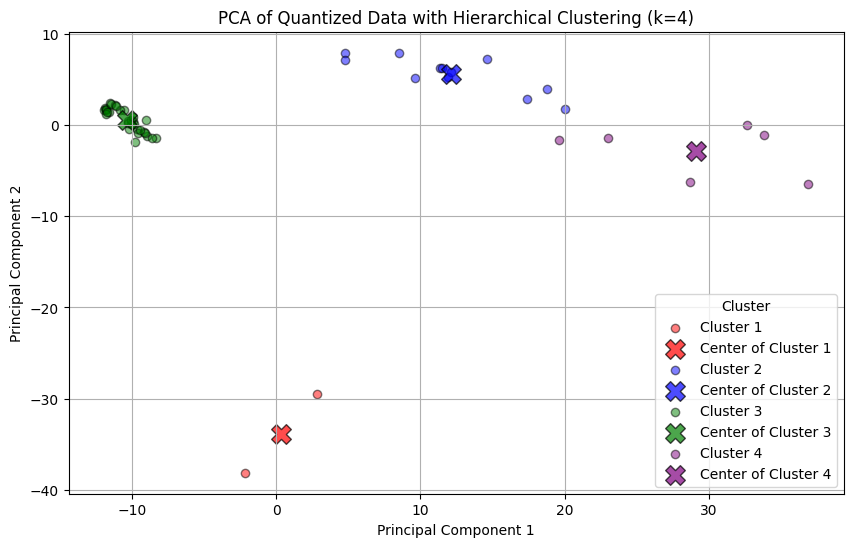

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# ตัดที่ระดับ 70
n_clusters = 4
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(X_scaled)

# เพิ่มคอลัมน์ Cluster ลงใน DataFrame ของ PCA
principalDf['Cluster'] = cluster_labels

# กำหนดสีสำหรับแต่ละกลุ่ม
colors = ['red', 'blue', 'green', 'purple']

# Plot the PCA results
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    # เลือกข้อมูลที่อยู่ในกลุ่มนั้น ๆ
    cluster_data = principalDf[principalDf['Cluster'] == cluster]
    # Plot จุดของแต่ละกลุ่ม
    plt.scatter(cluster_data['principal component 1'], cluster_data['principal component 2'],
                color=colors[cluster], label=f'Cluster {cluster + 1}', alpha=0.5, edgecolors='k')

    # คำนวณจุดศูนย์กลางของแต่ละกลุ่ม
    center_x = cluster_data['principal component 1'].mean()
    center_y = cluster_data['principal component 2'].mean()

    # Plot จุดศูนย์กลาง
    plt.scatter(center_x, center_y, color=colors[cluster], edgecolor='black',
                s=200, marker='X', label=f'Center of Cluster {cluster + 1}', alpha=0.7)  # ใช้ marker='X' เพื่อแสดงเป็นจุดศูนย์กลาง

# เพิ่ม legend และตั้งค่าแสดงผล
plt.legend(title='Cluster')
plt.title('PCA of Quantized Data with Hierarchical Clustering (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [47]:
principalDf.groupby('Cluster').size()

,0
Cluster,
0,2
1,12
2,31
3,6


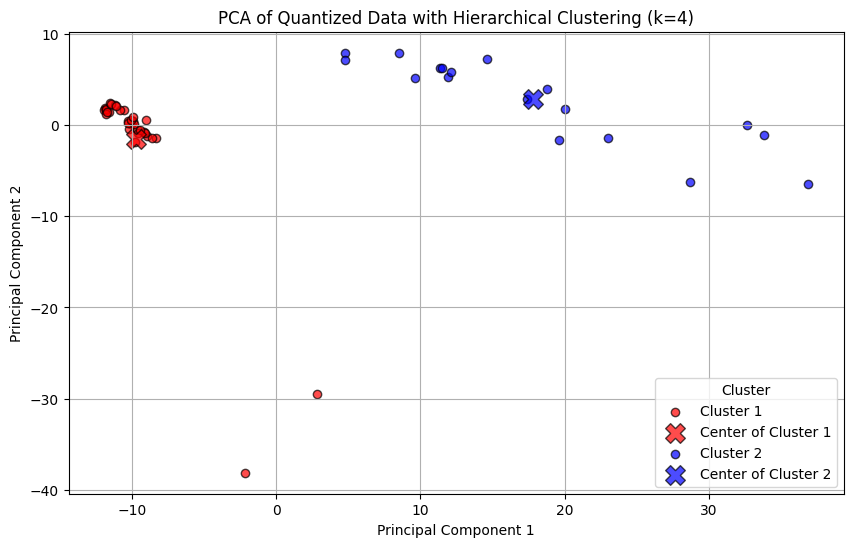

In [48]:
# ตัดตรง 120
n_clusters = 2
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(X_scaled)

# เพิ่มคอลัมน์ Cluster ลงใน DataFrame ของ PCA
principalDf['Cluster'] = cluster_labels

# กำหนดสีสำหรับแต่ละกลุ่ม
colors = ['red', 'blue', 'green', 'purple']

# Plot the PCA results
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = principalDf[principalDf['Cluster'] == cluster]
    plt.scatter(cluster_data['principal component 1'], cluster_data['principal component 2'],
                color=colors[cluster], label=f'Cluster {cluster + 1}', alpha=0.7, edgecolors='k')


    # คำนวณจุดศูนย์กลางของแต่ละกลุ่ม
    center_x = cluster_data['principal component 1'].mean()
    center_y = cluster_data['principal component 2'].mean()

    # Plot จุดศูนย์กลาง
    plt.scatter(center_x, center_y, color=colors[cluster], edgecolor='black',
                s=200, marker='X', label=f'Center of Cluster {cluster + 1}', alpha=0.7)  # ใช้ marker='X' เพื่อแสดงเป็นจุดศูนย์กลาง

# เพิ่ม legend และตั้งค่าแสดงผล
plt.legend(title='Cluster')
plt.title('PCA of Quantized Data with Hierarchical Clustering (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [49]:
principalDf.groupby('Cluster').size()

,0
Cluster,
0,33
1,18
